In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def RBF_Network(N, M):
    print("No. of Centers:",M)
    X = np.zeros((N,2))
    eta = 1
    resolution = 1000 
    desired_ouput = list()
    X_plus = list()
    X_minus = list()
    
    W = np.zeros((M,1))
    for i in range(M):
        W[i][0] = random.uniform(-1,1)
    theta = np.random.uniform(-1,1)
    
    CC_plus = np.zeros((int(M/2),2))
    CC_minus = np.zeros((int(M/2),2))
    l = 0
    m = 0
    CC_plus_index = []
    CC_minus_index = []
    for i in range(0, N):
        temp = np.random.uniform(0, 1, 2)
        X[i][0] = temp[0]
        X[i][1] = temp[1]
        
        if (X[i][1] < ((1 / 5) * np.sin(10 * X[i][0]) + 0.3)) or (
        (math.pow((X[i][1] - 0.8), 2) + math.pow((X[i][0] - 0.5), 2))) < math.pow(0.15, 2):
            
            desired_ouput.append(1)
            if l < int(M/2):
                CC_plus[l][0] = temp[0]
                CC_plus[l][1] = temp[1]
                l = l + 1
                CC_plus_index.append(i)
                plt.plot(X[i][0], X[i][1], 'ro')
            else:
                X_plus.append(temp)
                plt.plot(X[i][0], X[i][1], 'rx')
        else:
            desired_ouput.append(-1)
            if m < int(M/2):
                CC_minus[m][0]= temp[0]
                CC_minus[m][1] = temp[1]
                m = m +1
                CC_minus_index.append(i)
                plt.plot(X[i][0], X[i][1], 'bo')
            else:
                X_minus.append(temp)
                plt.plot(X[i][0], X[i][1],'bx')
    
    plt.ylabel('xi2')
    plt.xlabel('xi1')
    if(M == 20):
        plt.title('Classification using RBF with 20 centers')
    else:
        plt.title('Classification using RBF with 4 centers')

    CC_plus_final, class_plus_clusters = kmeans(CC_plus, X_plus, M)
    CC_minus_final, class_minus_clusters = kmeans(CC_minus, X_minus, M)
    
    for i in range(int(M/2)):
        plt.plot(CC_plus_final[i][0], CC_plus_final[i][1], 'ko')
        plt.plot(CC_minus_final[i][0], CC_minus_final[i][1], 'mo')
    
    k = 0
    for value in CC_plus_index:
        X[value] = CC_plus_final[k]
        k = k +1
    
    k = 0
    for value in CC_minus_index:
        X[value] = CC_minus_final[k]
        k = k +1
    
    C = np.zeros((M,2))
    for i in range(int(M/2)):
        C[i] = CC_plus_final[i]
    for i in range(int(M/2)):
        C[int(M/2)+i] = CC_minus_final[i]

    flag = 1
    epoch = 1
    accuracy = 0
    while(flag):
        classification_error = 0
        Y = np.zeros((N,1))
        g_X = calculate_output(W, X, C, N, M, theta)
        for i in range(N):
            
            Y[i][0] = signum_function(g_X[i][0])
            if desired_ouput[i] != Y[i]:
                classification_error = classification_error + 1
        W = update_weights(W, eta, X, C, desired_ouput, Y, N, M)
        accuracy = 100 - classification_error
        print("Epoch:",epoch," Classification_error:",classification_error," Accuracy:",accuracy,"%")
        
        if M >= 20:
            if classification_error == 0:
                flag = 0
            else:
                epoch = epoch + 1
        else:
            if classification_error <= 25:
                flag = 0
            else:
                epoch = epoch + 1
    print("Last Epoch No:",epoch," Final Accuracy:",accuracy,"%")     
    plot_classification_boundry(resolution, W, M, theta, X, C)
    plt.show()                

In [3]:
def plot_classification_boundry(resolution, W, M, theta, X, C):
    
    variance = np.var(X) 
    for x1 in range(resolution):
        for x2 in range(resolution):
            xx1 = x1/resolution
            xx2 = x2/resolution
            g =0
            x_array = np.array([xx1,xx2])
            for j in range(M):
                rbf = math.exp(-1 * (np.linalg.norm(x_array - C[j])**2)/ (2 * (variance**2)))
                g = g + (W[j][0] * rbf)
            g = g + theta
            if g < 0.1 and g > -0.1:
                plt.plot(xx1,xx2,'b.', markersize =3)

In [4]:
def kmeans(CC, class_X, M):
    
    X_matrix = np.matrix(np.array(class_X))
    count = 0
    flag = 1
    while(flag):
        class_clusters = {}
        for i in range (int(M/2)):
            class_clusters.setdefault(i, [])
        for i in range(class_X.__len__()):
            dist = []
            for j in range(int(M/2)):
                dist.append(np.linalg.norm(X_matrix[i] - CC[j]))
            min_dist_index = np.argmin(dist)   
            class_clusters[min_dist_index].append(X_matrix[i])
    
        for i in range(int(M/2)):
            sum = 0
            if len(class_clusters[i]) != 0:
                for j in range(len(class_clusters[i])):
                    sum = sum + class_clusters[i][j]
                new_CC = sum/len(class_clusters[i])
            
                diff = np.linalg.norm(new_CC - CC[i])
                # print("diff:",diff)
                CC[i] = new_CC
                if diff == 0:
                    flag = 0    
        count = count + 1
       
    return CC, class_clusters

In [5]:
def signum_function(x):
    if x >= 0:
        return 1
    else:
        return -1

In [6]:
def calculate_output(W, X, C, N, M, theta):
    variance = np.var(X)
    g_X = np.zeros((N,1))
    for i in range(N):
        for j in range(M):
            rbf = math.exp(-1 * (np.linalg.norm(X[i] - C[j])**2)/ (2 * (variance**2)))
            g_X[i][0] = g_X[i][0] + W[j][0] * rbf
        g_X[i][0] = g_X[i][0] + theta
    return g_X

In [7]:
def update_weights(W, eta, X, C, d, Y, N, M):
    variance = np.var(X)
    RBF = np.zeros((N, 1))
    for i in range(N):
        for j in range(M):
            RBF[i][0] = RBF[i][0] + (math.exp(-1 * (np.linalg.norm(X[i] - C[j])**2) / (2 * (variance**2))))
            W[j][0] = W[j][0] + eta * RBF[i][0] * (d[i] - Y[i])
    return W

No. of Centers: 4
Epoch: 1  Classification_error: 53  Accuracy: 47 %
Epoch: 2  Classification_error: 32  Accuracy: 68 %
Epoch: 3  Classification_error: 28  Accuracy: 72 %
Epoch: 4  Classification_error: 28  Accuracy: 72 %
Epoch: 5  Classification_error: 29  Accuracy: 71 %
Epoch: 6  Classification_error: 27  Accuracy: 73 %
Epoch: 7  Classification_error: 27  Accuracy: 73 %
Epoch: 8  Classification_error: 26  Accuracy: 74 %
Epoch: 9  Classification_error: 33  Accuracy: 67 %
Epoch: 10  Classification_error: 35  Accuracy: 65 %
Epoch: 11  Classification_error: 29  Accuracy: 71 %
Epoch: 12  Classification_error: 28  Accuracy: 72 %
Epoch: 13  Classification_error: 28  Accuracy: 72 %
Epoch: 14  Classification_error: 29  Accuracy: 71 %
Epoch: 15  Classification_error: 27  Accuracy: 73 %
Epoch: 16  Classification_error: 26  Accuracy: 74 %
Epoch: 17  Classification_error: 26  Accuracy: 74 %
Epoch: 18  Classification_error: 26  Accuracy: 74 %
Epoch: 19  Classification_error: 26  Accuracy: 74 %
Epo

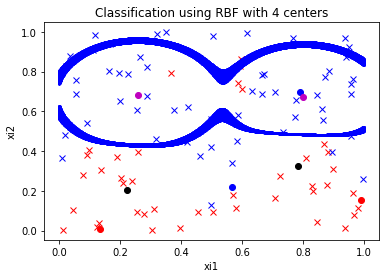

In [9]:
RBF_Network(100, 4)

No. of Centers: 20
Epoch: 1  Classification_error: 61  Accuracy: 39 %
Epoch: 2  Classification_error: 62  Accuracy: 38 %
Epoch: 3  Classification_error: 27  Accuracy: 73 %
Epoch: 4  Classification_error: 13  Accuracy: 87 %
Epoch: 5  Classification_error: 12  Accuracy: 88 %
Epoch: 6  Classification_error: 9  Accuracy: 91 %
Epoch: 7  Classification_error: 9  Accuracy: 91 %
Epoch: 8  Classification_error: 7  Accuracy: 93 %
Epoch: 9  Classification_error: 7  Accuracy: 93 %
Epoch: 10  Classification_error: 7  Accuracy: 93 %
Epoch: 11  Classification_error: 6  Accuracy: 94 %
Epoch: 12  Classification_error: 6  Accuracy: 94 %
Epoch: 13  Classification_error: 4  Accuracy: 96 %
Epoch: 14  Classification_error: 6  Accuracy: 94 %
Epoch: 15  Classification_error: 5  Accuracy: 95 %
Epoch: 16  Classification_error: 5  Accuracy: 95 %
Epoch: 17  Classification_error: 5  Accuracy: 95 %
Epoch: 18  Classification_error: 5  Accuracy: 95 %
Epoch: 19  Classification_error: 4  Accuracy: 96 %
Epoch: 20  Class

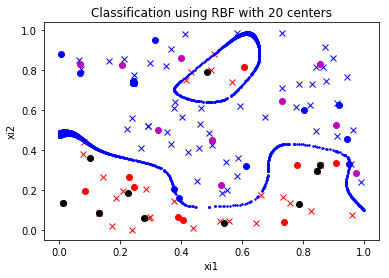

In [8]:
RBF_Network(100, 20)